# Optimization of a power system
Student: Bruno Kiyoshi Ynumaru; Prof. Eduardo Camponogara

In this exercise, you will have the opportunity to approximate a nonlinear problem
as a MILP by means of piecewise-linear models. The power system has 3 buses
as depicted in Fig. 1. Buses 1 and 3 have generation units, whereas bus 2 is a
power consumer. This Figures also gives the maximum power generation ($\bar{P_{gi}}$) and
the power consumption ($\bar{P_{di}}$) of each bus i, under low and high demand. The
properties of the transmission lines appear in Table 1, in pu using a 100 MVA basis,
are indicated in the Figure. The parameters are the resistance $r_{i,j}$ , the reactance $x_{i,j}$
and the number of lines installed between buses i and j.


<img src="Figure1.jpg" alt="Drawing" style="width: 400px; margin-left:auto; margin-right:auto"/>

|Line| $r_{i,j}$ (pu)| $x_{i,j}$ (pu)| ni,j|
|----|---------------|---------------|----------|
|1-2 | 0.030         |0.23           |2         |
|1-3 |0.035          | 0.25          |1         |
|2-3 | 0.025         | 0.20          |1         |

A simplified model is adopted for the transmission network, in which:  
•Lines and transformers are represented by their series impedances in per unit:  
\begin{equation}
z_{i,j} = r_{i,j} + jx_{i,j} \space \space (1)
\end{equation}
where ri;j is the resistance and xi;j is the reactance of line (i; j).  
• Voltage magnitudes are fixed at 1:0 pu.  
• Reactive power balance is supposed to be satisfied.  
With these assumptions, active power flows are expressed as  
\begin{equation}
p.flow \space i \rightarrow j : P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}) \space (2a)\\
p.flow \space j \rightarrow i : P_{j,i} = g_{i,j}-(g_{i,j} cos\theta_{i,j} - b_{i,j} sin \theta_{i,j}) \space (2b) 
\end{equation}  
where $gij$ and $b_{ij}$ are, respectively, the series conductance and series susceptance of
line (i, j), $\theta_{i,j} = (\theta_i - \theta_j)$ and $\theta_i$ is the voltage angle of bus i.  
Conductance and susceptance are calculated as follows  
\begin{equation}
g_{i,j}=\frac{r_{i,j}}{(r^2_{i,j}+x^2_{i,j})}\\
b_{i,j}=-\frac{x_{i,j}}{(r^2_{i,j}+x^2_{i,j})}
\end{equation}  
The power injected into bus i is defined as  
\begin{equation}
P_i=\sum_{j \in N_i} n_{i,j}P_{i,j} = \sum_{j \in N_i}n_{i,j}[g_{i,j}-(g_{i,j}cos\theta_{i,j}+b_{i,j}sin\theta_{i,j}])] \space (3)
\end{equation}  
where $N_i$ is the set of neighboring buses of bus i. To ensure energy conservation, the
following equations must also be satisfied  
\begin{equation}
Pg_i=\bar{Pd_i}+P_i \space (4)
\end{equation}  
Aiming to minimize the power loss in transmission, the power-flow optimization problem could be solved:  

\begin{align}
min &\sum_{i \in N} |P_i| \\
s.t:& Pg_i=\bar{Pd_i}+P_i, \\
&P_i=\sum_{j \in N_i} n_{i,j}P_{i,j}, \\
&0 \le Pg_i \le \bar{Pg_i}, \\
&\theta_i \in [\frac{-\pi}{2},\frac{\pi}{2}, i \in N],  \\
&P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}),\\
&\theta_{i,j}=\theta_i-\theta_j, \\
&\theta_{i,j} \in [-\pi,\pi], i \in N, j \in N_i
\end{align}

Tasks:  
• Reformulate the power-flow optimization problem in MILP using the following piecewise-linear models: CC and SOS2.  
• Implement the models in AMPL, choosing a suitable number of breakpoints to induce a good approximation of the power-flow equations. You may plot the piecewise linear approximations for sin $\theta_{i,j}$ and cos \theta_{i,j} in order to show the degree of approximation.  
• Solve the problem for the low and high power demand cases. Present and illustrate the solutions.  

### Modeling the SOS2 constraint in linear terms

\begin{equation} 
\lambda_i^n \in [ 0, +\infty ], i = 0,...,{{P}^n - 1} \\
z_i^n \in \{0,1\} , i = 0,...,{{P}^n - 1} \\
\lambda_i^n \le z_i , i = 0,...,{{P}^n - 1} \\
\sum_{i=0}^{P^n-1} z_i \le 2 \\
z_i^n + z_j^n \le 1, (i,j) \in \{i+2,...,P^n-1\}^2
\end{equation}

## Optimization problem solution using Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB, Model
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

Piece of code for reading and presenting field data: 

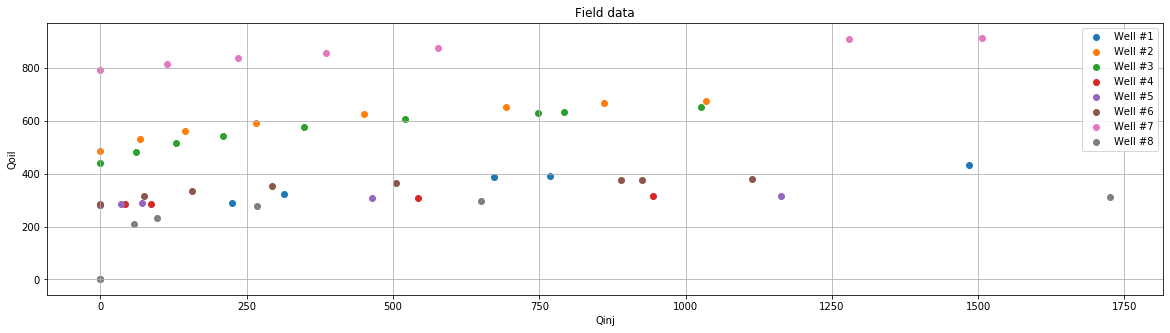

In [3]:
N = 8 
wells = [item for item in range(1, N+1)] # Create a list with the well indexes as given by the problem.
data_df = pd.read_excel('data.xlsx')
data = {}
plt.rcParams['figure.figsize'] = [20, 5]
for n in wells:
    filtered = data_df[data_df.n == n]
    data[n] = (filtered.Qinj.values, filtered.Qoil.values)
    plt.scatter(data[n][0], data[n][1], label=f"Well #{n}")
plt.grid()
plt.legend()
plt.xlabel("Qinj")
plt.ylabel("Qoil")
plt.title("Field data")
plt.show()

Modeling and solving the problem using Gurobi:

In [4]:
# Minimum and maximum injection rates for each well (data extracted from p1.dat)
# The data is parsed into dictionaries so they can be indexed from 1 to 8, this following the well numerations as given by the problem.
lb_inj = {n:[225, 68, 60, 42, 35, 74, 114, 58][n-1] for n in wells}
ub_inj = {n:[1485, 1035, 1027, 945, 1164, 1114, 1507, 1525][n-1] for n in wells}

# Water cut and gas-oil-ratio parameters for each well (data extracted from p1.dat)
WCut = {n:[0.4567, 0.4824, 0.4579, 0.3716, 0.0159, 0.3474, 0.0934, 0.1380][n-1] for n in wells}
GOR = {n:[1.9642, 0.7188, 0.6052, 3.0000, 3.6952, 1.3798, 0.6587, 2.1919][n-1] for n in wells}

# Maximum liquid and gas handling downstream (data extracted from p1.dat)
Qliq_max = 5500
Qgas_max = 6000

listQoil_optimal = []
listQinj_max = range(0, 1500, 10)
results_dict = {}
for Qinj_max in listQinj_max:
    
    # Create a new model
    m = Model("GLC")
    m.Params.OutputFlag = 0 # Suppress output
    
    # Define variables
    y = m.addVars(wells, vtype=GRB.BINARY, name="y")
    Qinj = m.addVars(wells, vtype=GRB.CONTINUOUS, name="Qinj")
    Qoil = m.addVars(wells, vtype=GRB.CONTINUOUS, name="Qoil")
    Qw = m.addVars(wells, vtype=GRB.CONTINUOUS, name="Qw")
    Qg = m.addVars(wells, vtype=GRB.CONTINUOUS, name="Qg")
    
    # Set constraints
    
    # This creates the piecewise linear reformulations for each well into our model object
    pwlf = {}
    for n in wells:
        pwlf[n] = m.addGenConstrPWL(Qinj[n], Qoil[n], data[n][0], data[n][1], f"Qoil(Qinj) well {n}")
    
    m.addConstrs((Qw[n]==(WCut[n]/(1-WCut[n])) * Qoil[n] for n in wells), "WaterProduction_equality") # eq. (1b)
    m.addConstr(Qw.sum() + Qoil.sum() <= Qliq_max, "LiqProcessingConstr")# eq. (2c)

    m.addConstrs((Qg[n]==GOR[n] * Qoil[n] for n in wells), "GasProduction_equality") # eq. (1a)
    m.addConstr(Qinj.sum() + Qg.sum()<=Qgas_max, "GasProcessingConstr") # eq. (2d)

    m.addConstr(Qinj.sum() <= Qinj_max, "MaxTotalInjectionConstr") # eq. (2b)

    m.addConstrs((Qinj[n] >= y[n]*lb_inj[n] for n in wells), "MinInjectionConstr") # eq. (2g)
    m.addConstrs((Qinj[n] <= y[n]*ub_inj[n] for n in wells), "MaxInjectionConstr") # eq. (2g)

    # Set objective function
    m.setObjective(Qoil.sum(), GRB.MAXIMIZE) # eq. (2a)

    m.update()
    m.optimize()
    
    # Feed results into a dictionary which can be fed to a Pandas DataFrame for further exploration:
    results_dict[Qinj_max] = {**{"Qoil":m.getObjective().getValue()},**{var.VarName: var.x for var in m.getVars()},  **{f"Slack({constr.ConstrName})": constr.Slack for constr in m.getConstrs() if "_equality" not in constr.ConstrName }}


Academic license - for non-commercial use only - expires 2022-03-12
Using license file C:\Users\Bruno\gurobi.lic


In [5]:
# Create pandas dataframe for easier data handling
results_df = pd.DataFrame.from_dict(results_dict, orient="index")
results_df.index.name = "Qinj_max"
results_df.to_excel("results_complete.xlsx")

### Objective (Qoil) and operation conditions for different maximum injection capacity:
Below we present the optimal gas-lift injection rates for each maximum injection capacity, as well as the objective value:

In [6]:
pd.options.display.float_format = '{:.2f}'.format
QinjColFilter = [colname for colname in results_df.columns if "Qinj" in colname]
QinjColFilter.append("Qoil")
results_df[QinjColFilter][::5]

,Qinj[1],Qinj[2],Qinj[3],Qinj[4],Qinj[5],Qinj[6],Qinj[7],Qinj[8],Qoil
Qinj_max,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2566.00
50,0.00,0.00,0.00,0.00,50.00,0.00,0.00,0.00,2571.67
100,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,2799.75
150,0.00,0.00,60.00,0.00,0.00,0.00,0.00,90.00,2834.69
200,0.00,68.00,60.00,0.00,0.00,0.00,0.00,72.00,2866.62
250,0.00,68.00,85.00,0.00,0.00,0.00,0.00,97.00,2894.68
300,225.00,0.00,0.00,0.00,0.00,0.00,0.00,75.00,3075.46
350,225.00,0.00,60.00,0.00,0.00,0.00,0.00,65.00,3109.31
400,225.00,0.00,78.00,0.00,0.00,0.00,0.00,97.00,3138.13


### Effect of maximum injection capacity on total oil production:

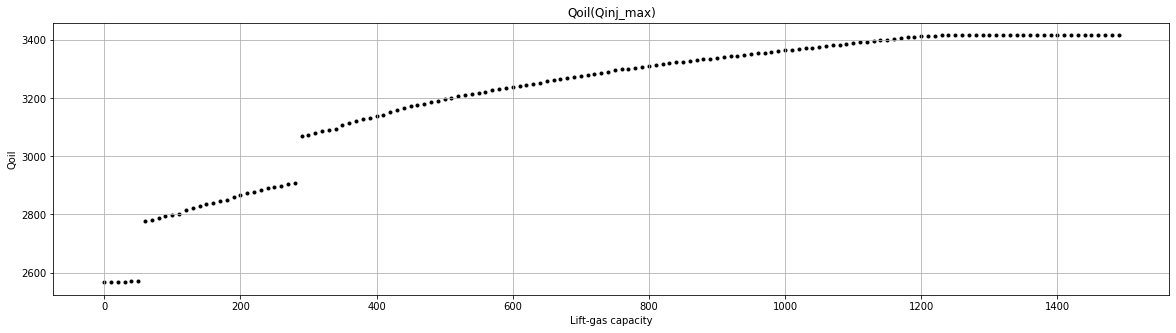

In [7]:
fig = plt.figure()
plt.scatter(results_df.index, results_df["Qoil"], marker='.', c='black')
plt.ylabel('Qoil')
plt.xlabel('Lift-gas capacity')
plt.title("Qoil(Qinj_max)")
plt.grid(which="both")
plt.show()

### Optimal lift-gas injection for varying Qinj_max

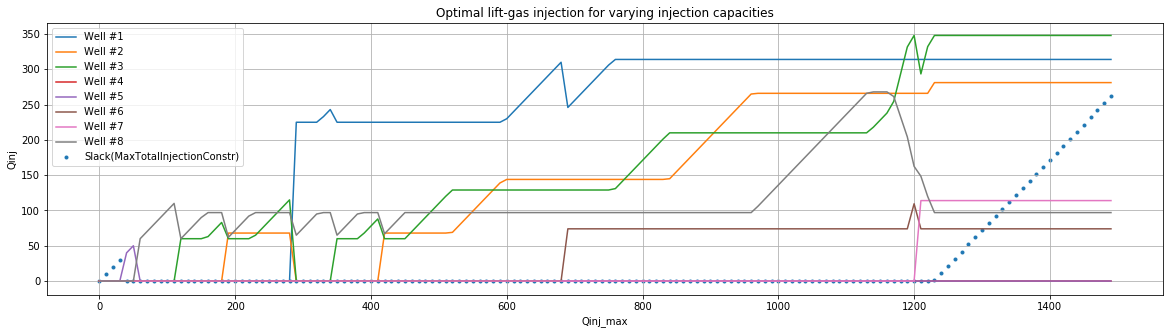

In [8]:
for n in wells:
    plt.plot(results_df.index, results_df[f"Qinj[{n}]"], label = f"Well #{n}")
plt.scatter(results_df.index, results_df["Slack(MaxTotalInjectionConstr)"], label = "Slack(MaxTotalInjectionConstr)", marker=".")
plt.legend()
plt.grid(which="both")
plt.title("Optimal lift-gas injection for varying injection capacities")
plt.ylabel("Qinj")
plt.xlabel("Qinj_max")
plt.show()

### Active constraints
Below, we plot the slacks for each of the problem's constraints so we can have an idea of which constraints are active at any maximum injection capacity. Analyzing which constraints are active at any Qinj_max can help explain big leaps in the objective.

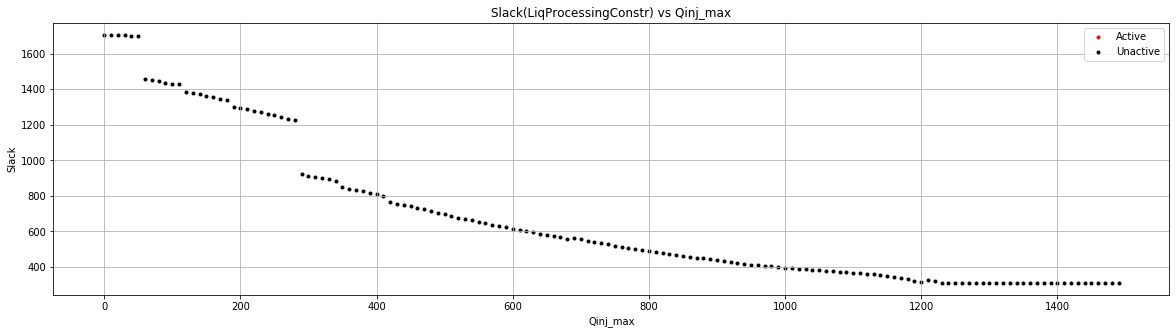

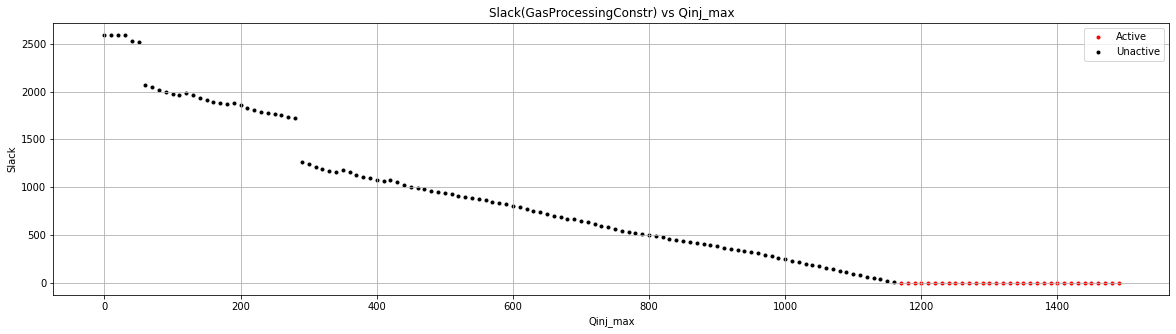

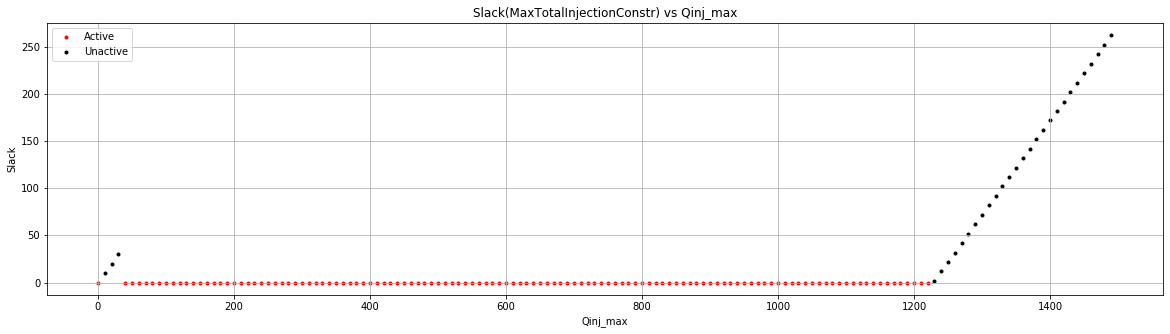

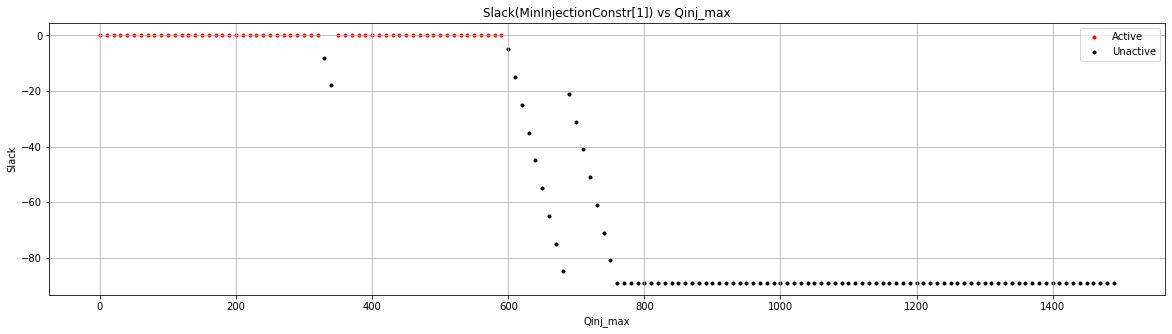

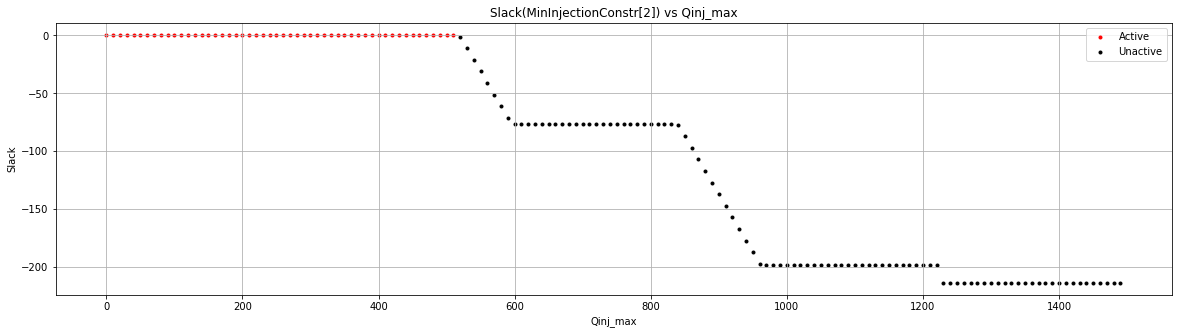

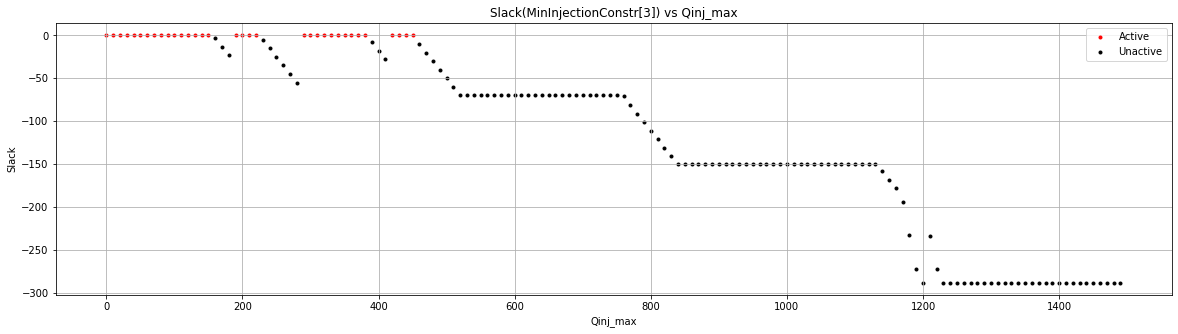

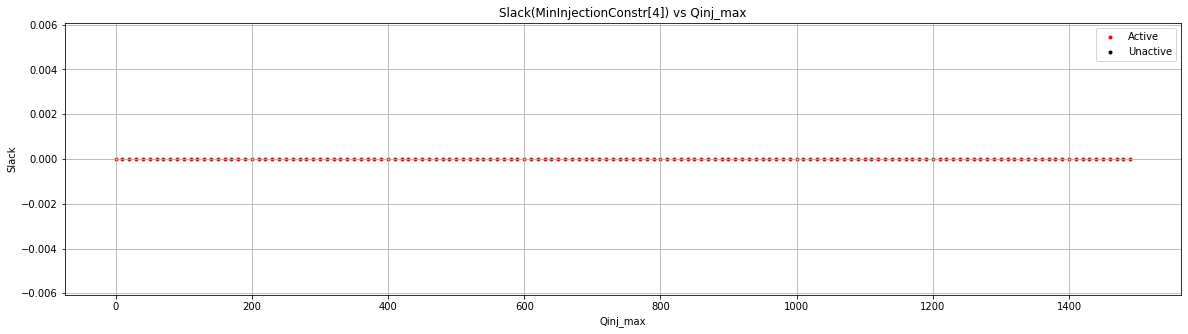

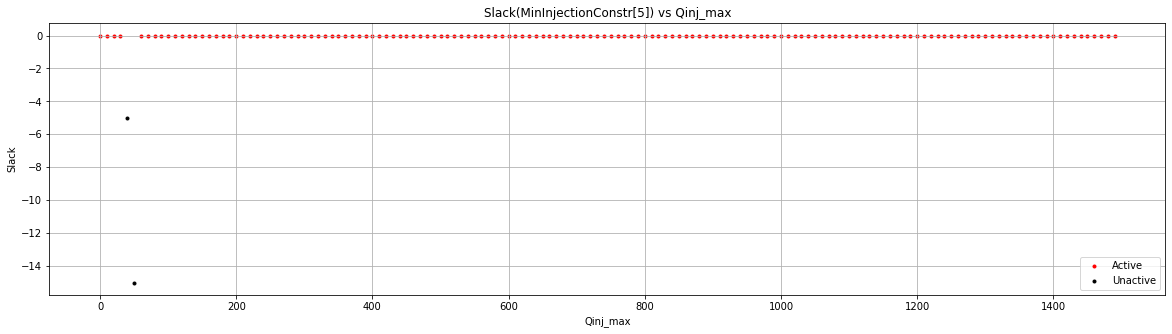

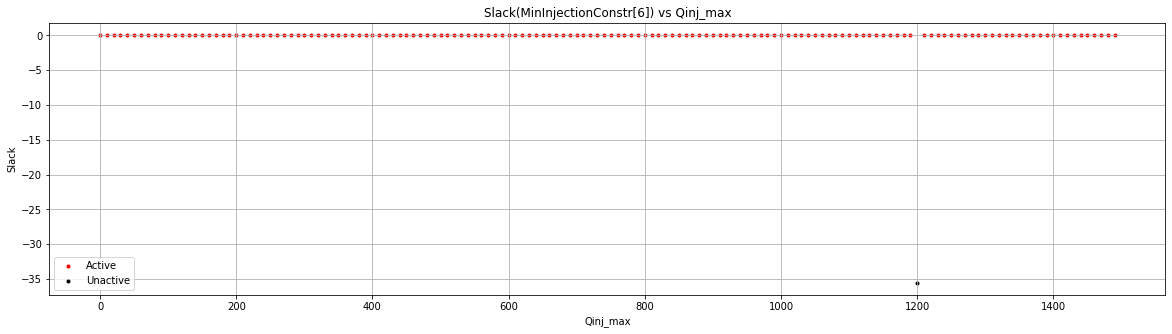

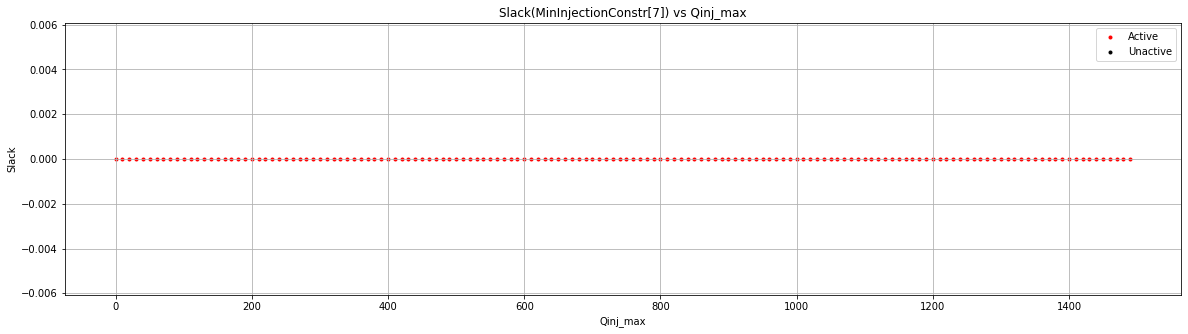

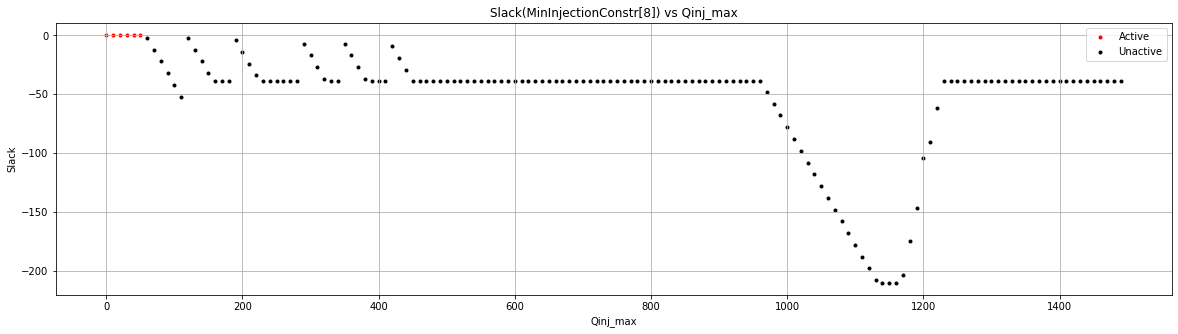

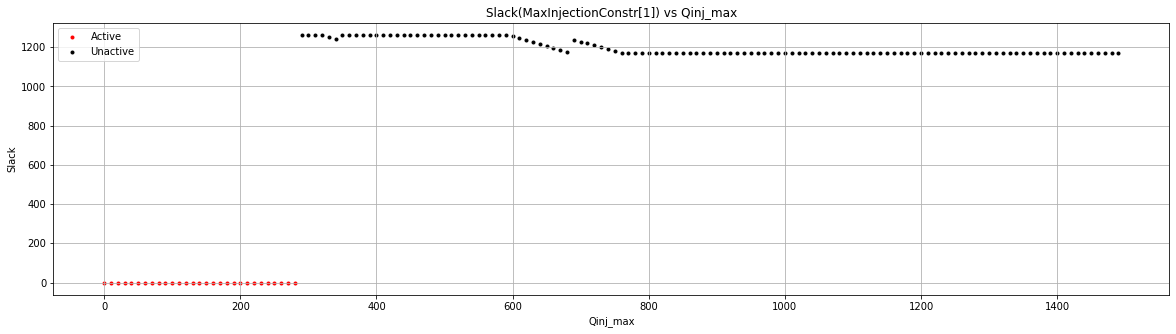

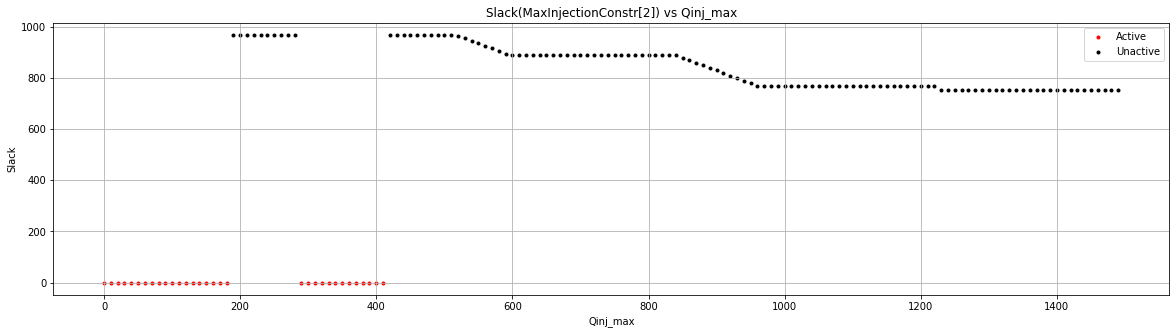

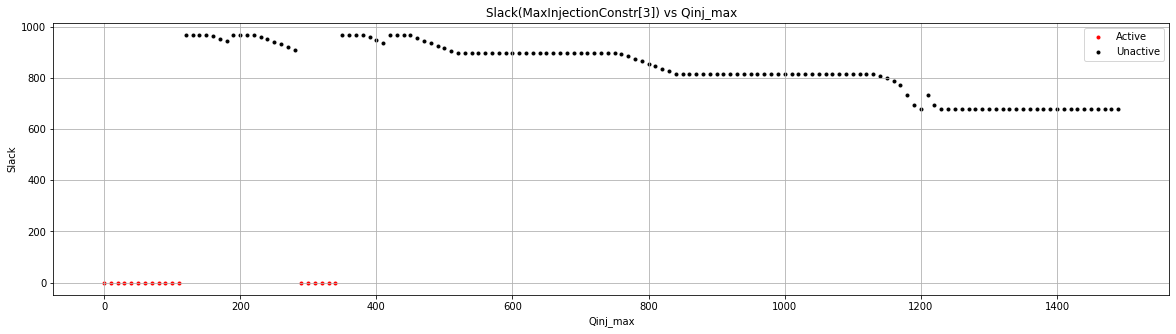

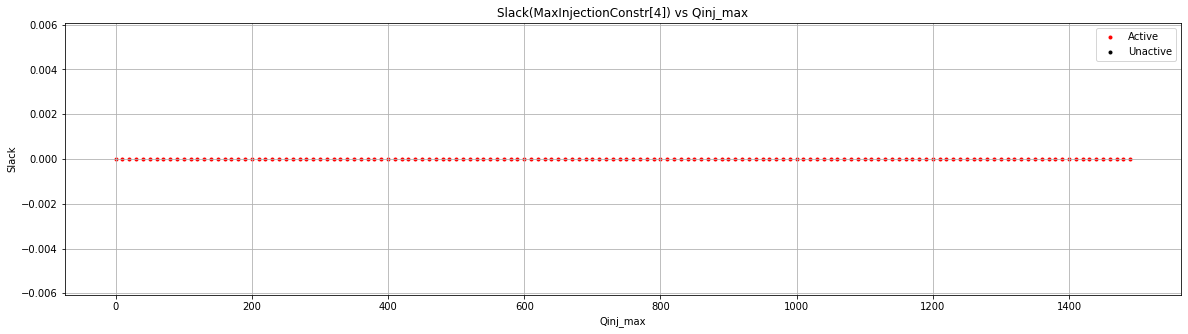

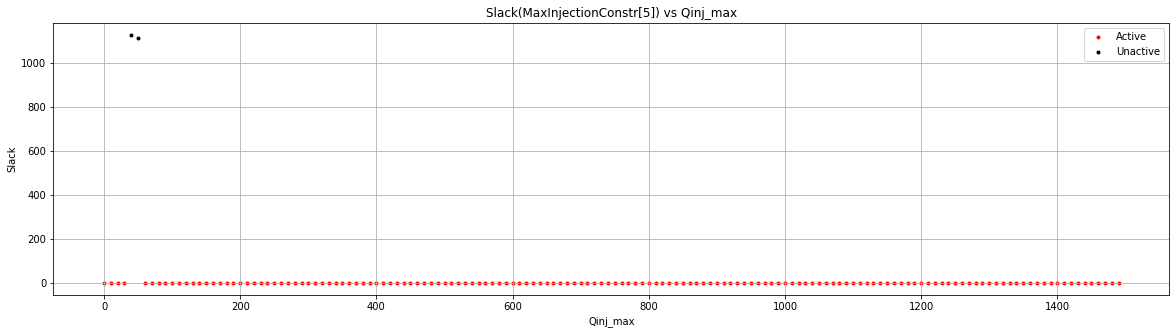

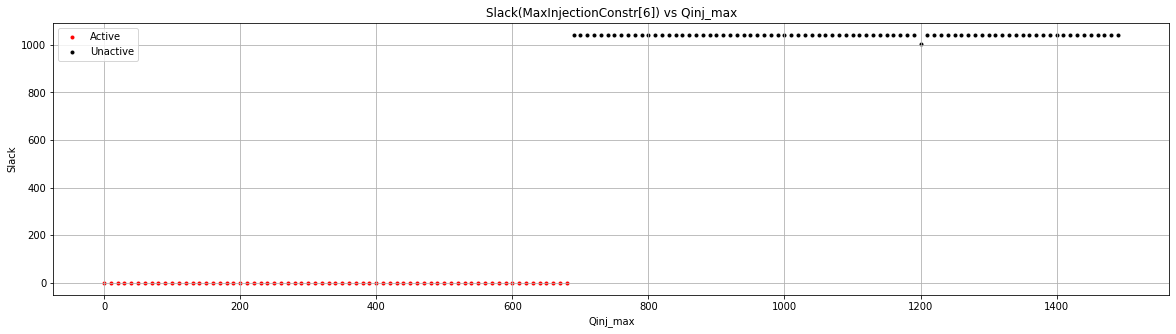

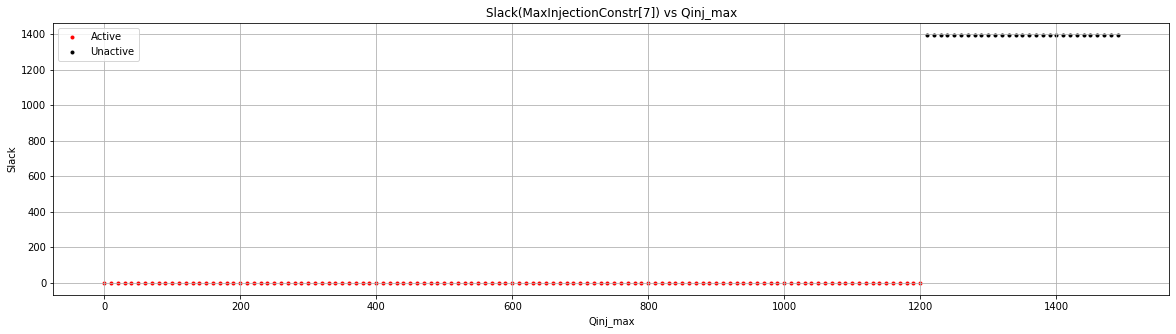

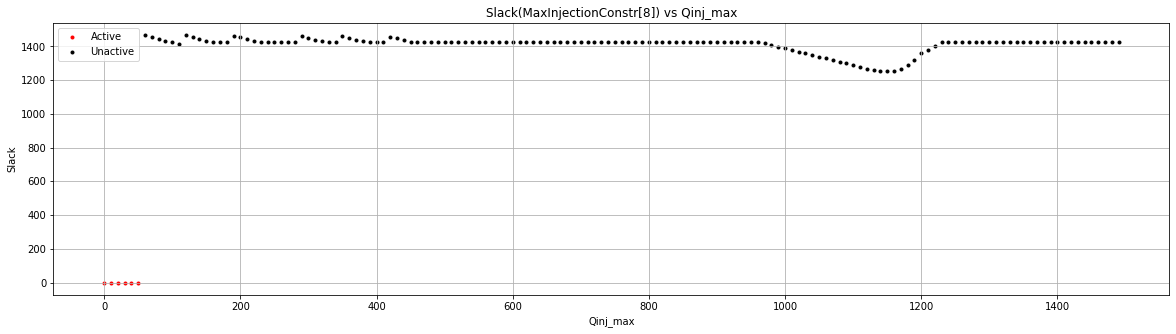

In [9]:
for column in results_df:
    if "Slack" in column:
        plt.scatter(results_df.index[results_df[column].values**2 < 1e-5], results_df[column][results_df[column].values**2 < 1e-5], label = "Active", marker=".", color="red")
        plt.scatter(results_df.index[results_df[column].values**2 > 1e-5], results_df[column][results_df[column].values**2 >1e-5], label = "Unactive", marker=".", color="black")
        plt.xlabel("Qinj_max")
        plt.ylabel("Slack")
        plt.legend()
        plt.title(f"{column} vs Qinj_max")
        plt.grid(which="both")
        plt.show()

Obs: the complete results, including binary variables and water and gas production rates can be seen in the "results_complete.xlsx" file.